In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from scipy.integrate import odeint
from ibm_nb_init import indep_init, ibm_init
from fenrir_filter import *
from jax.config import config
from filter_inference import filter_inference

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
theta_diffrax = np.load('saves/fitz_theta_diffrax.npy')
theta_kalman = np.load('saves/fitz_theta_kalman.npy')[0:2]
y_obs = np.load("saves/fitz_Y_t.npy")
config.update("jax_enable_x64", True)


In [2]:
def fitz0(X_t, t, theta):
    a, b, c = theta
    V, R = X_t 
    return np.array([c*(V - V*V*V/3 + R), -1/c*(V - a + b*R)])

def ode_fun(X, t, theta):
    "FitzHugh-Nagumo ODE function for jax."
    a, b, c = theta
    p = len(X)//2
    V, R = X[0], X[p]
    return jnp.array([c*(V - V*V*V/3 + R),
                      -1/c*(V - a + b*R)])

def ode_funpad(X, t, theta):
    a, b, c = theta
    p = len(X)//2
    V, R = X[0], X[p]
    return jnp.array([V, c*(V - V*V*V/3 + R), 0,
                      R, -1/c*(V - a + b*R), 0])

def obs_fun(y, Cx, gamma, theta):
    mu_obs, var_obs = gamma
    mu = Cx + mu_obs
    return jsp.stats.multivariate_normal.logpdf(y, mu, var_obs)

In [3]:
# problem setup and intialization
n_deriv = 1  # Total state
n_meas = 2  # Total measures
n_deriv_prior = 3
n_obs = 40
n_dim_obs = 2

n_order = jnp.array([n_deriv_prior]*n_meas)

# it is assumed that the solution is sought on the interval [tmin, tmax].
tmin = 0.
tmax = 40.

# logprior parameters
theta_true = np.array([0.2, 0.2, 3]) # True theta
n_theta = len(theta_true)
phi_mean = np.zeros(n_theta)
phi_sd = np.log(10)*np.ones(n_theta) 

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
sigma = .1
sigma = jnp.array([sigma]*n_meas)

# Initial x0 for odeint
ode0 = np.array([-1., 1.])

# Initial x0 for jax
x0_block = jnp.array([[-1., 1., 0.], [1., 1/3, 0.]])
x0_state = x0_block.flatten()

# Initial W for jax non block
W = np.zeros((n_meas, jnp.sum(n_order)))
W[0, 1] = 1
W[1, n_deriv_prior+1] = 1
W = jnp.array(W)

key = jax.random.PRNGKey(0)

# observations
tseq1 = np.linspace(tmin, tmax, n_obs+1)
exact = odeint(fitz0, ode0, tseq1, args=(theta_true,))
gamma = .2
e_t = np.random.default_rng(0).normal(loc=0.0, scale=1, size=exact.shape)
y_obs2 = exact + gamma*e_t
y_obs2 = jnp.array(y_obs2)
mu_obs = jnp.zeros((n_dim_obs,))
wgt_obs = np.zeros((n_dim_obs, jnp.sum(n_order)))
wgt_obs[0,0] = 1
wgt_obs[1, n_deriv_prior] = 1
wgt_obs = jnp.array(wgt_obs)
var_obs = gamma**2*jnp.eye((n_dim_obs))

In [4]:
res_lst = np.array([10, 20]) 
n_samples = 100000
phi_init = jnp.log(theta_true)
phi_init = np.append(np.log(theta_true), ode0)
theta_filter = np.zeros((len(res_lst), n_samples, len(phi_init)))
for r,n_res in enumerate(res_lst):
    n_eval = n_obs*n_res
    print(n_eval)
    # Get parameters for non block
    dt = (tmax-tmin)/n_eval
    ode_init = ibm_init(dt, n_order, sigma)
    kinit = indep_init(ode_init, n_order)
    ode_init = dict((k, jnp.array(v)) for k, v in kinit.items())
    
    inf = filter_inference(key, tmin, tmax, ode_fun)
    inf.W = W
    inf.n_res = n_res
    inf.mu_state = ode_init['mu_state']
    inf.wgt_state = ode_init['wgt_state']
    inf.var_state = ode_init['var_state']
    inf.mu_obs = mu_obs
    inf.wgt_obs = wgt_obs
    inf.var_obs = var_obs
    inf.funpad = ode_funpad

    phi_hat, phi_var = inf.phi_fit(y_obs, np.array([None, None]), phi_mean, phi_sd, phi_init, inf.fenrir_nlpost)
    
    theta_filter[r] = inf.phi_sample(phi_hat, phi_var, n_samples)
    theta_filter[r, :, :n_theta] = np.exp(theta_filter[r, :, :n_theta])
# np.save('saves/fitz_theta_filter.npy', theta_filter)

400
800


In [7]:
def x_fun(x, y, theta):
    return x

In [5]:
plt.rcParams.update({'font.size': 20})
# var_names = ['a', 'b', 'c']
var_names = ['a', 'b', 'c', r"$V_0^{(0)}$", r"$R_0^{(0)}$"]
param_true = np.append(theta_true, np.array([-1, 1]))

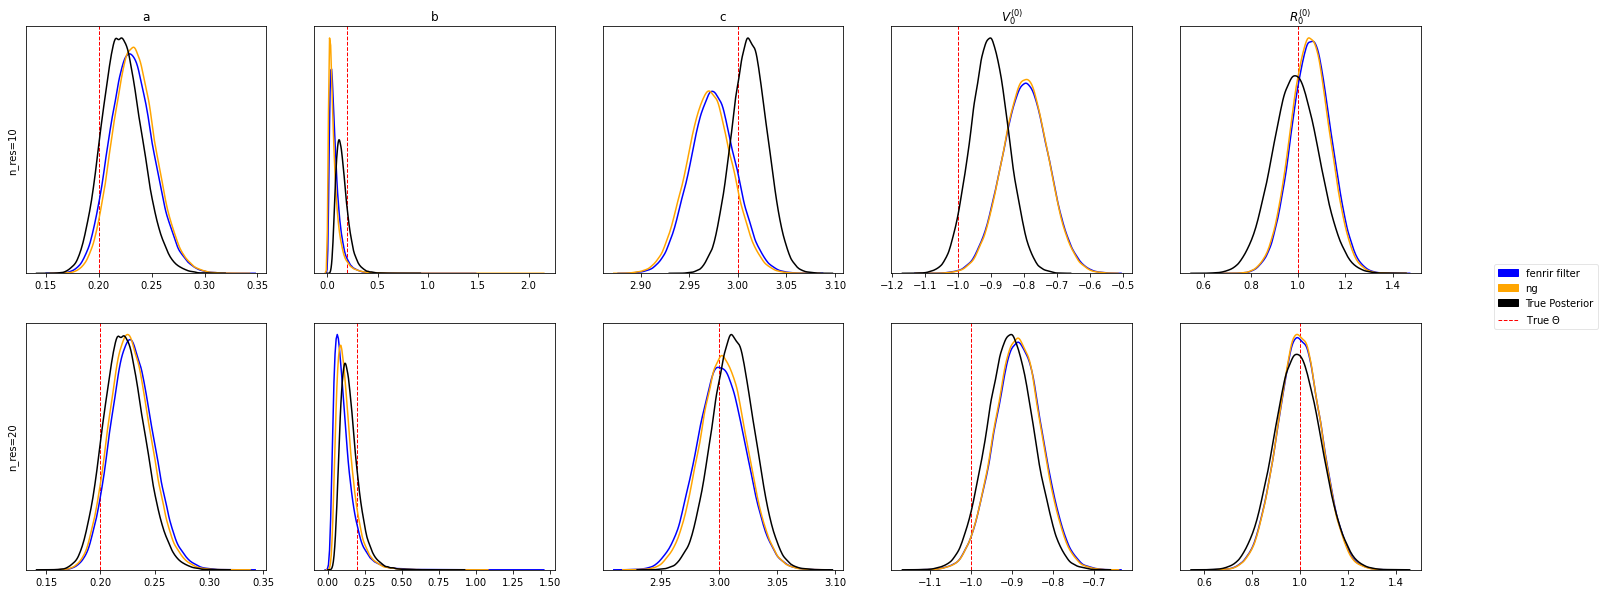

In [6]:
n_row = len(res_lst)
fig, axs = plt.subplots(n_row, 5, figsize=(25, 5*n_row))
for r in range(n_row):
    for i in range(theta_filter.shape[-1]):
        axs[r,i].axvline(x=param_true[i], linewidth=1, color='r', linestyle='dashed')
        sns.kdeplot(theta_filter[r, :, i], ax=axs[r,i], color="blue")
        sns.kdeplot(theta_kalman[r, :, i], ax=axs[r,i], color="orange")
        sns.kdeplot(theta_diffrax[:, i], ax=axs[r,i], color='black')
        axs[r,i].set(ylabel=None,yticks=[])
        if r==0:
            axs[r, i].set(title=var_names[i])
    axs[r,0].set(ylabel='n_res={}'.format(res_lst[r]))
    
patches = [None]*4
patches[0] = mpatches.Patch(color='blue', label='fenrir filter')
patches[1] = mpatches.Patch(color='orange', label='ng')
patches[2] = mpatches.Patch(color='black', label="True Posterior")
patches[3] = mlines.Line2D([], [], color='r', linestyle='dashed', linewidth=1, label='True $\\Theta$')
fig.legend(handles=patches, framealpha=0.5, loc=7)
# fig.tight_layout()

In [2]:
class seirahinf(filter_inference):
    r"Inference using the France Covid data from Prague et al."
        
    def ode_fun(self, X_t, t, theta):
        "SEIRAH ODE function"
        p = len(X_t)//6
        S, E, I, R, A, H = X_t[::p]
        N = S + E + I + R + A + H
        b, r, alpha, D_e, D_I, D_q= theta
        D_h = 30
        x1 = -b*S*(I + alpha*A)/N
        x2 = b*S*(I + alpha*A)/N - E/D_e
        x3 = r*E/D_e - I/D_q - I/D_I
        x4 = (I + A)/D_I + H/D_h
        x5 = (1-r)*E/D_e - A/D_I
        x6 = I/D_q - H/D_h
        return jnp.array([x1, x2, x3, x4, x5, x6])

    def rax_fun(self, t, X_t, theta):
        "SEIRAH ODE function"
        p = len(X_t)//6
        S, E, I, R, A, H = X_t[::p]
        N = S + E + I + R + A + H
        b, r, alpha, D_e, D_I, D_q= theta
        D_h = 30
        x1 = -b*S*(I + alpha*A)/N
        x2 = b*S*(I + alpha*A)/N - E/D_e
        x3 = r*E/D_e - I/D_q - I/D_I
        x4 = (I + A)/D_I + H/D_h
        x5 = (1-r)*E/D_e - A/D_I
        x6 = I/D_q - H/D_h
        return jnp.array([x1, x2, x3, x4, x5, x6])

    def x0_initialize(self, phi, x0, phi_len):
        j = 0
        xx0 = []
        for i in range(len(x0)):
            if x0[i] is None:
                xx0.append(jnp.exp(phi[phi_len+j]))
                j+=1
            else:
                xx0.append(x0[i])
        return jnp.array(xx0)
    
    def covid_obs(self, X_t, theta):
        r"Compute the observations as detailed in the paper"
        I_in = theta[1]*X_t[0]/theta[3]
        H_in = X_t[1]/theta[5]
        X_in = jnp.array([I_in, H_in]).T
        return X_in
    
    def simulate(self, x0, theta, tseq):
        r"""Get the observations for the SEIRAH Covid example.
        None of the compartments are directly observed, however 
        the daily infections and hospitalizations are observed. 
        They can be computed as
        
        .. math::

            I^{(in)}(t) = rE(t)/D_e
            H^{(in)}(t) = I(t)/D_q

        """
        X_t = odeint(self.ode_fun, x0, tseq, args=(theta,)).T
        X_t = X_t[1:3]
        X_in = self.covid_obs(X_t, theta)
        Y_in = np.random.default_rng(111).poisson(X_in)
        return Y_in, X_t

    def obs_fun(self, y_t, x_t, gamma, theta):
        X_in = self.covid_obs(x_t, theta)
        return jnp.sum(jsp.stats.poisson.logpmf(y_t, X_in))
    

In [3]:
def seirah(X_t, t, theta):
    "SEIRAH ODE function"
    p = len(X_t)//6
    S, E, I, R, A, H = X_t[::p]
    N = S + E + I + R + A + H
    b, r, alpha, D_e, D_I, D_q= theta
    D_h = 30
    x1 = -b*S*(I + alpha*A)/N
    x2 = b*S*(I + alpha*A)/N - E/D_e
    x3 = r*E/D_e - I/D_q - I/D_I
    x4 = (I + A)/D_I + H/D_h
    x5 = (1-r)*E/D_e - A/D_I
    x6 = I/D_q - H/D_h
    return jnp.array([x1, x2, x3, x4, x5, x6])


def seirahpad(X_t, t, theta):
    p = len(X_t)//6
    S, E, I, R, A, H = X_t[::p]
    N = S + E + I + R + A + H
    b, r, alpha, D_e, D_I, D_q = theta
    D_h = 30
    x1 = -b*S*(I + alpha*A)/N
    x2 = b*S*(I + alpha*A)/N - E/D_e
    x3 = r*E/D_e - I/D_q - I/D_I
    x4 = (I + A)/D_I + H/D_h
    x5 = (1-r)*E/D_e - A/D_I
    x6 = I/D_q - H/D_h
    
    out = jnp.array([S, x1, 0,
                     E, x2, 0,
                     I, x3, 0, 
                     R, x4, 0,
                     A, x5, 0,
                     H, x6, 0])
    return out

In [4]:
# problem setup and intialization
n_deriv = 1  # Total state
n_meas = 6  # Total measures
n_deriv_prior = 3
n_dim_obs = 2
n_obs = 60

# it is assumed that the solution is sought on the interval [tmin, tmax].
n_eval = 150
tmin = 0.
tmax = 60.
theta = np.array([2.23, 0.034, 0.55, 5.1, 2.3, 1.13])
thetaj = jnp.array(theta)

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
sigma = jnp.array([.5]*n_meas)

# W matrix for the IVP
W_mat = np.zeros((n_meas, 1, n_deriv_prior))
W_mat[:, :, 1] = 1
W_block = jnp.array(W_mat)

# Initial x0 for odeint
ode0 = np.array([63804435., 15492., 21752., 0., 618013., 93583.])

# Initial x0 for jax block
x0 = jnp.array([63804435, 15492, 21752, 0, 618013, 93583])
v0 = seirah(x0, 0, theta)
xx0 = np.array([63884630, None, None, 0, 618013, 13388]) 

# Get parameters needed to run the solver
dt = (tmax-tmin)/n_eval
n_order = jnp.array([n_deriv_prior]*n_meas)
ode_init = ibm_init(dt, n_order, sigma)

# Initial W for jax non block
W = np.zeros((n_meas, jnp.sum(n_order)))
for i in range(n_meas):
    W[i, n_deriv+i*n_deriv_prior] = 1
W = jnp.array(W)

# Initial x0 for non block
x0_state = jnp.ravel(jnp.array([x0, v0, jnp.zeros((n_meas,))]), order='F')

# logprior parameters
theta_true = np.array([2.23, 0.034, 0.55, 5.1, 2.3, 1.13]) # True theta
n_theta = len(theta_true)
phi_mean = np.zeros(n_theta)
phi_sd = np.log(10)*np.ones(n_theta)

# Number of samples to draw from posterior
n_samples = 100000
# Initialize inference class and simulate observed data
key = jax.random.PRNGKey(0)
inf = seirahinf(key, tmin, tmax, seirah)
inf.funpad = seirahpad
tseq = np.linspace(tmin, tmax, int(tmax-tmin + 1))
Y_t, X_t = inf.simulate(ode0, theta, tseq)

In [5]:
obs_fun = inf.obs_fun
def x_fun(x, y, theta):
    return x

In [6]:
ng_jit = jax.jit(fenrir_filterng, static_argnums=(0, 5))
n_res = 10
n_eval = n_obs*n_res
dt = (tmax-tmin)/n_eval
ode_init = ibm_init(dt, n_order, sigma)
kinit = indep_init(ode_init, n_order)
ode_init = dict((k, jnp.array(v)) for k, v in kinit.items())

In [7]:
wgt_obs = np.zeros((n_dim_obs, jnp.sum(n_order)))
for i in range(n_dim_obs):
    wgt_obs[i, (i+1)*n_deriv_prior] = 1
wgt_obs = jnp.array(wgt_obs)


In [15]:
n_res = 10
n_eval = n_obs*n_res

# Get parameters for non block
dt = (tmax-tmin)/n_eval
ode_init = ibm_init(dt, n_order, sigma)
kinit = indep_init(ode_init, n_order)
ode_init = dict((k, jnp.array(v)) for k, v in kinit.items())

inf = seirahinf(key, tmin, tmax, seirah)
inf.W = W
inf.n_res = n_res
inf.mu_state = ode_init['mu_state']
inf.wgt_state = ode_init['wgt_state']
inf.var_state = ode_init['var_state']
inf.wgt_obs = wgt_obs
inf.funpad = seirahpad
inf.x_fun = x_fun

In [8]:
res_lst = np.array([10, 20]) 
n_samples = 100000
# phi_init = jnp.log(theta_true)
phi_init = np.append(np.log(theta_true), np.log(np.array([15492, 21752])))
theta_filter2 = np.zeros((len(res_lst), n_samples, n_theta+2))
for r,n_res in enumerate(res_lst):
    n_eval = n_obs*n_res

    # Get parameters for non block
    dt = (tmax-tmin)/n_eval
    ode_init = ibm_init(dt, n_order, sigma)
    kinit = indep_init(ode_init, n_order)
    ode_init = dict((k, jnp.array(v)) for k, v in kinit.items())

    inf = seirahinf(key, tmin, tmax, seirah)
    inf.W = W
    inf.n_res = n_res
    inf.mu_state = ode_init['mu_state']
    inf.wgt_state = ode_init['wgt_state']
    inf.var_state = ode_init['var_state']
    inf.wgt_obs = wgt_obs
    inf.funpad = seirahpad
    inf.x_fun = x_fun

    phi_hat, phi_var, phi_fisher = inf.phi_fit(Y_t, xx0, phi_mean, phi_sd, phi_init, inf.fenrir_nlpostng)
    
    theta_filter2[r] = inf.phi_sample(phi_hat, phi_var, n_samples)
    theta_filter2[r] = np.exp(theta_filter2[r])
# np.save('saves/fitz_theta_filter.npy', theta_filter)

In [9]:
var_names = ["b", "r", r"$\alpha$", "$D_e$", "$D_I$", "$D_q$", "$E(0)}$", "$I(0)}$"]
clip = [(0, 8), None, (0,2), None, None, None, (0, 30000), None]
param_true = np.append(theta_true, np.array([15492, 21752]))

In [10]:
theta_diffrax = np.load('saves/seirah_theta_diffrax.npy')

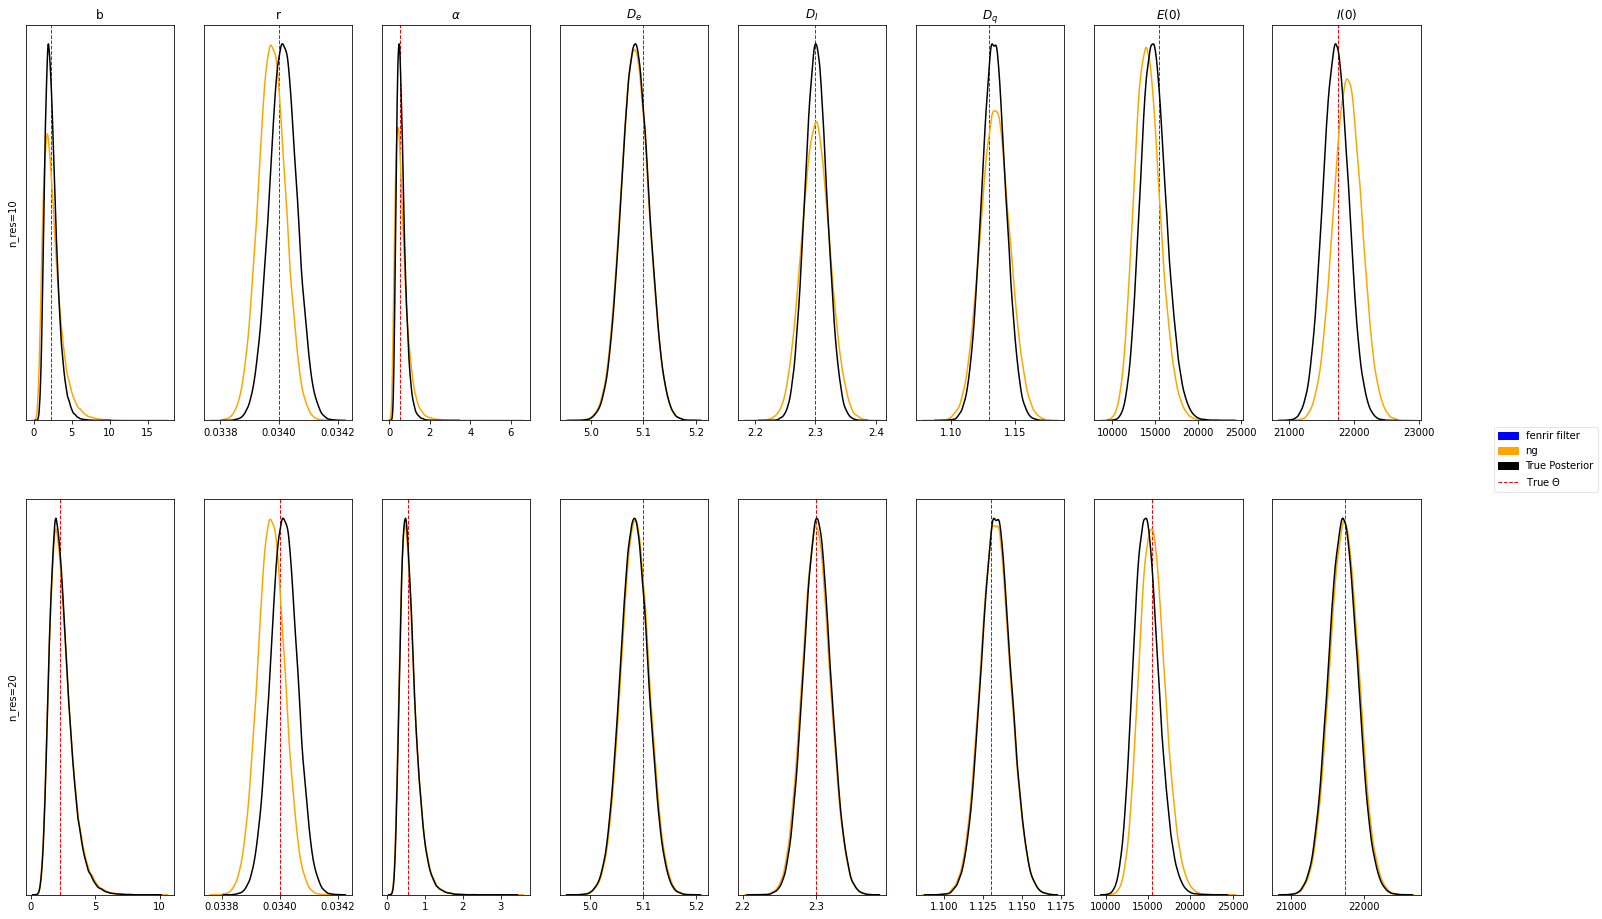

In [11]:
n_row = len(res_lst)
fig, axs = plt.subplots(n_row, n_theta+2, figsize=(25, (n_theta+2)*n_row))
for r in range(n_row):
    for i in range(theta_filter2.shape[-1]):
        axs[r,i].axvline(x=param_true[i], linewidth=1, color='r', linestyle='dashed')
        # sns.kdeplot(theta_filter[r, :, i], ax=axs[r,i], color="blue")
        sns.kdeplot(theta_filter2[r, :, i], ax=axs[r,i], color="orange")
        sns.kdeplot(theta_diffrax[:, i], ax=axs[r,i], color='black')
        axs[r,i].set(ylabel=None,yticks=[])
        if r==0:
            axs[r, i].set(title=var_names[i])
    axs[r,0].set(ylabel='n_res={}'.format(res_lst[r]))
    
patches = [None]*4
patches[0] = mpatches.Patch(color='blue', label='fenrir filter')
patches[1] = mpatches.Patch(color='orange', label='ng')
patches[2] = mpatches.Patch(color='black', label="True Posterior")
patches[3] = mlines.Line2D([], [], color='r', linestyle='dashed', linewidth=1, label='True $\\Theta$')
fig.legend(handles=patches, framealpha=0.5, loc=7)
# fig.tight_layout()